In [2]:
!pip install pydriller


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.2 MB/s eta 0:00:00


Cloning maxtext...

Overall Discrepancy counts (maxtext):
Discrepancy
No     6669
Yes    3058
Name: count, dtype: int64

Discrepancy counts per file type (maxtext):
Source files: 2288
Test files: 686
Readme files: 83
License files: 1


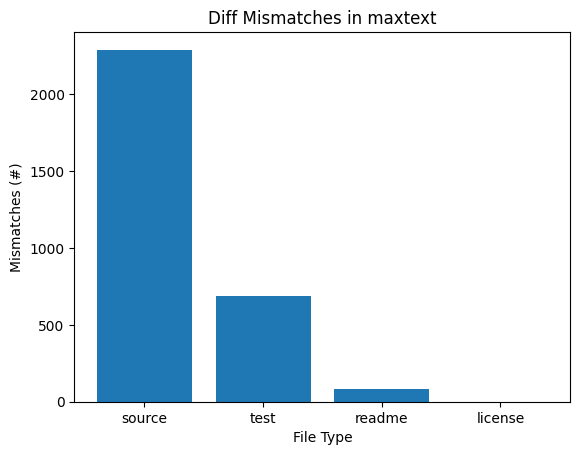

Cloning elegantrl...

Overall Discrepancy counts (elegantrl):
Discrepancy
Yes    6734
No     3472
Name: count, dtype: int64

Discrepancy counts per file type (elegantrl):
Source files: 6581
Test files: 60
Readme files: 54
License files: 39


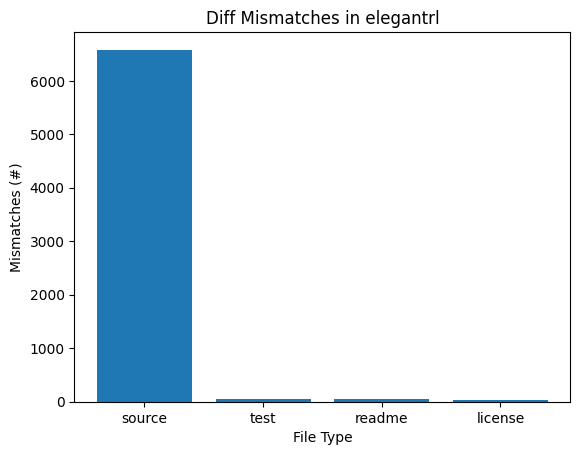

Cloning flask...

Overall Discrepancy counts (flask):
Discrepancy
No     3701
Yes    2256
Name: count, dtype: int64

Discrepancy counts per file type (flask):
Source files: 2143
Test files: 58
Readme files: 46
License files: 9


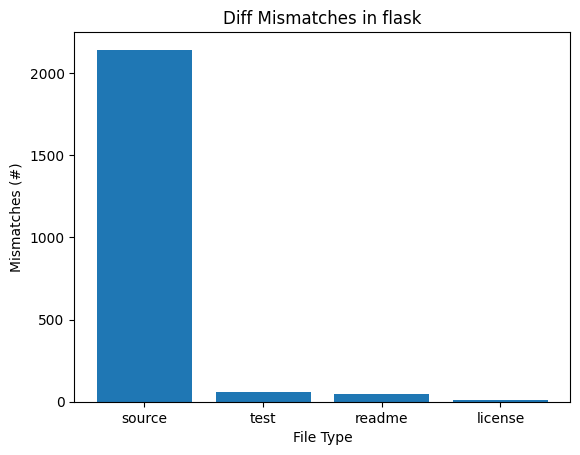

In [3]:
from pydriller import Repository
import pandas as pd
import csv
import subprocess
import os
import matplotlib.pyplot as plt

# ---------- Helper Functions ----------

# Run histogram diff
def get_hist_diff(repo_path, commit_hash, file_path):
    if file_path is None or file_path == "nan":
        return ""
    try:
        cmd = [
            "git", "-C", repo_path, "diff", "--histogram",
            f"{commit_hash}^", commit_hash, "--", file_path
        ]
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
        return result.stdout
    except Exception as e:
        return str(e)

# Clean diff: remove metadata lines, normalize whitespace
def clean_diff(diff_str):
    cleaned = []
    for line in str(diff_str).splitlines():
        line = line.strip()
        if not line:
            continue
        # Skip diff metadata lines
        if line.startswith("diff --git") or line.startswith("index ") \
           or line.startswith("---") or line.startswith("+++") \
           or line.startswith("@@"):
            continue
        cleaned.append(line)
    return "\n".join(cleaned)

# Extract commit diffs
def extract_repo_diffs(repo_url, local_path, output_csv, repo_name):
    # Clone repo if not present
    if not os.path.exists(local_path):
        print(f"Cloning {repo_name}...")
        subprocess.run(["git", "clone", repo_url, local_path])

    with open(output_csv, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            "repo_name",
            "old_file_path", "new_file_path",
            "commit_sha", "parent_commit_sha",
            "commit_message",
            "diff_myers", "diff_hist",
            "file_type"
        ])

        for commit in Repository(local_path).traverse_commits():
            parent_commits = commit.parents if commit.parents else ["None"]
            parent_str = ";".join(parent_commits)

            for modified_file in commit.modified_files:
                diff_myers = modified_file.diff if modified_file.diff else ""
                diff_hist = get_hist_diff(local_path, commit.hash, modified_file.new_path)

                # Categorize file type
                file_path = str(modified_file.new_path).lower() if modified_file.new_path else ""
                if "test" in file_path:
                    ftype = "test"
                elif "readme" in file_path:
                    ftype = "readme"
                elif "license" in file_path:
                    ftype = "license"
                else:
                    ftype = "source"

                writer.writerow([
                    repo_name,
                    modified_file.old_path,
                    modified_file.new_path,
                    commit.hash,
                    parent_str,
                    commit.msg,
                    diff_myers,
                    diff_hist,
                    ftype
                ])

# Add discrepancy column
def add_discrepancy(input_csv, output_csv):
    df = pd.read_csv(input_csv)

    df["Discrepancy"] = [
        "No" if clean_diff(row["diff_myers"]) == clean_diff(row["diff_hist"]) else "Yes"
        for _, row in df.iterrows()
    ]

    df.to_csv(output_csv, index=False)
    return df

# Generate stats + plot
def generate_stats_plot(df, repo_name):
    categories = {"source": 0, "test": 0, "readme": 0, "license": 0}

    for _, row in df.iterrows():
        if row["Discrepancy"] == "Yes":
            ftype = row["file_type"]
            if ftype in categories:
                categories[ftype] += 1

    # Print per file type
    print(f"\nDiscrepancy counts per file type ({repo_name}):")
    for k, v in categories.items():
        print(f"{k.capitalize()} files: {v}")

    # Plot
    plt.bar(categories.keys(), categories.values())
    plt.title(f"Diff Mismatches in {repo_name}")
    plt.xlabel("File Type")
    plt.ylabel("Mismatches (#)")
    plt.show()

# ---------- Main ----------

# List of 3 repos with local folder names
repos = [
    {"url": "https://github.com/AI-Hypercomputer/maxtext", "local": "maxtext", "name": "maxtext"},
    {"url": "https://github.com/ai4finance-foundation/elegantrl", "local": "elegantrl", "name": "elegantrl"},
    {"url": "https://github.com/assafelovic/gpt-researcher", "local": "gpt_researcher", "name": "flask"}
]

for repo in repos:
    raw_csv = f"{repo['name']}_diffs.csv"
    final_csv = f"{repo['name']}_final.csv"

    extract_repo_diffs(repo["url"], repo["local"], raw_csv, repo["name"])
    df_final = add_discrepancy(raw_csv, final_csv)

    # Overall discrepancy counts
    print(f"\nOverall Discrepancy counts ({repo['name']}):")
    print(df_final["Discrepancy"].value_counts())

    # Per file type stats + plot
    generate_stats_plot(df_final, repo["name"])



Overall Discrepancy counts (maxtext):
Discrepancy
No     6669
Yes    3058
Name: count, dtype: int64

Discrepancy counts per file type (maxtext):
Source files: 2288
Test files: 686
Readme files: 83
License files: 1


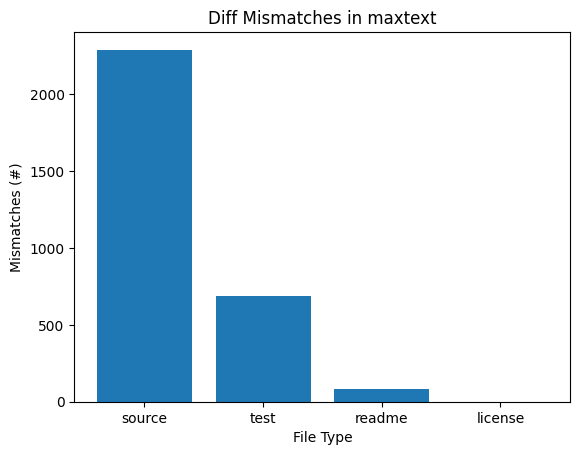


Algorithm comparison (maxtext):
Average lines in Myers diffs (for mismatches): 390.43
Average lines in Histogram diffs (for mismatches): 537.61
Suggestion: Myers diff might be closer to actual code changes.


Overall Discrepancy counts (elegantrl):
Discrepancy
Yes    6734
No     3472
Name: count, dtype: int64

Discrepancy counts per file type (elegantrl):
Source files: 6581
Test files: 60
Readme files: 54
License files: 39


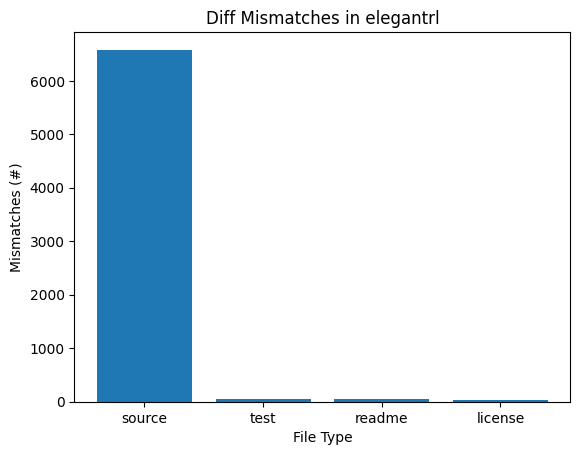


Algorithm comparison (elegantrl):
Average lines in Myers diffs (for mismatches): 904.05
Average lines in Histogram diffs (for mismatches): 942.19
Suggestion: Myers diff might be closer to actual code changes.


Overall Discrepancy counts (flask):
Discrepancy
No     3701
Yes    2256
Name: count, dtype: int64

Discrepancy counts per file type (flask):
Source files: 2143
Test files: 58
Readme files: 46
License files: 9


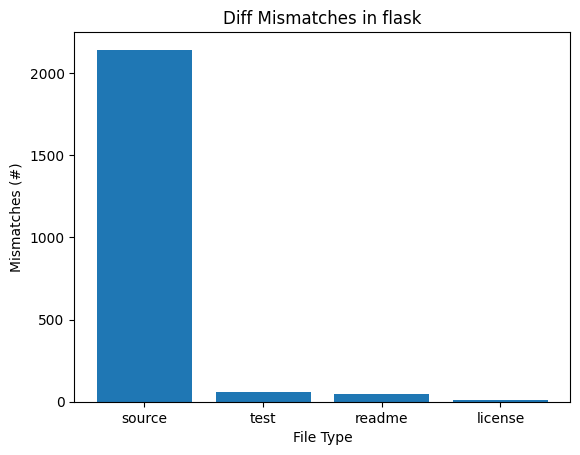


Algorithm comparison (flask):
Average lines in Myers diffs (for mismatches): 173.34
Average lines in Histogram diffs (for mismatches): 312.88
Suggestion: Myers diff might be closer to actual code changes.



In [4]:
for repo in repos:
    raw_csv = f"{repo['name']}_diffs.csv"
    final_csv = f"{repo['name']}_final.csv"

    extract_repo_diffs(repo["url"], repo["local"], raw_csv, repo["name"])
    df_final = add_discrepancy(raw_csv, final_csv)

    # Overall Discrepancy counts
    print(f"\nOverall Discrepancy counts ({repo['name']}):")
    print(df_final["Discrepancy"].value_counts())

    # Per file type stats + plot
    generate_stats_plot(df_final, repo["name"])

    # --- Algorithm comparison (inside loop) ---
    mismatch_df = df_final[df_final["Discrepancy"] == "Yes"].copy()
    mismatch_df["len_myers"] = mismatch_df["diff_myers"].apply(lambda x: len(str(x).splitlines()))
    mismatch_df["len_hist"] = mismatch_df["diff_hist"].apply(lambda x: len(str(x).splitlines()))

    avg_myers_len = mismatch_df["len_myers"].mean()
    avg_hist_len = mismatch_df["len_hist"].mean()

    print(f"\nAlgorithm comparison ({repo['name']}):")
    print(f"Average lines in Myers diffs (for mismatches): {avg_myers_len:.2f}")
    print(f"Average lines in Histogram diffs (for mismatches): {avg_hist_len:.2f}")

    if avg_myers_len < avg_hist_len:
        print("Suggestion: Myers diff might be closer to actual code changes.\n")
    elif avg_hist_len < avg_myers_len:
        print("Suggestion: Histogram diff might be closer to actual code changes.\n")
    else:
        print("Both algorithms perform similarly for this repo.\n")


/tmp/ipython-input-3035123983.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Algorithm", y="Diff Length", data=long_df, ax=axes[i, 2], palette="Set2")
/tmp/ipython-input-3035123983.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Algorithm", y="Diff Length", data=long_df, ax=axes[i, 2], palette="Set2")
/tmp/ipython-input-3035123983.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Algorithm", y="Diff Length", data=long_df, ax=axes[i, 2], palette="Set2")


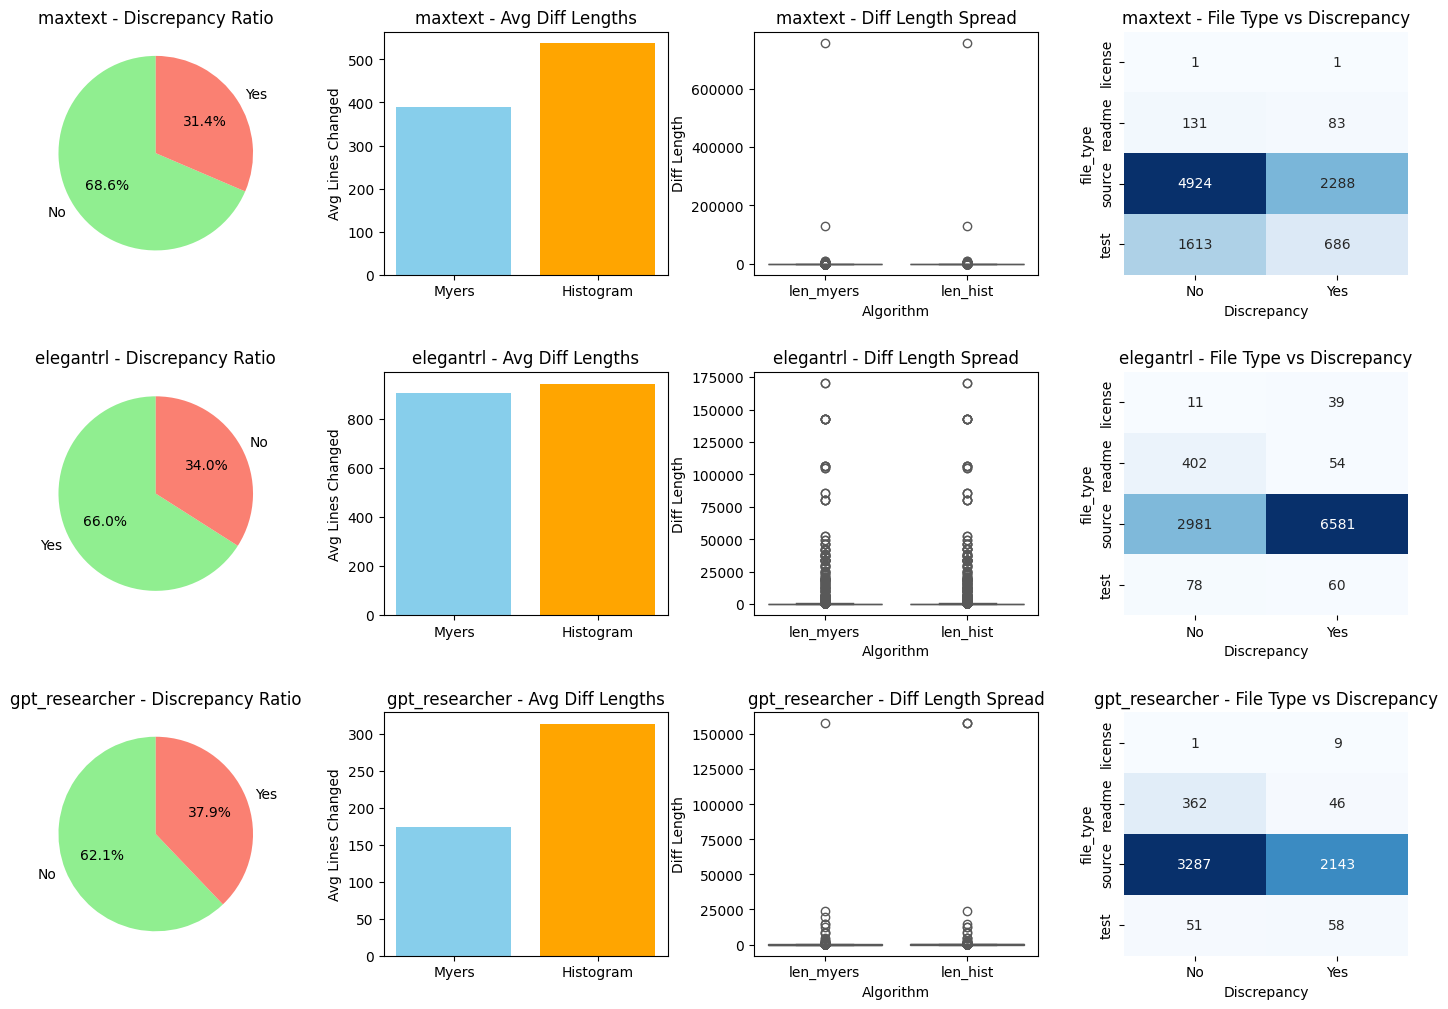

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

repos = [
    {"name": "maxtext", "csv": "maxtext_final.csv"},
    {"name": "elegantrl", "csv": "elegantrl_final.csv"},
    {"name": "gpt_researcher", "csv": "flask_final.csv"}
]

fig, axes = plt.subplots(len(repos), 4, figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, repo in enumerate(repos):
    df = pd.read_csv(repo["csv"])

    # ✅ 1. Pie chart
    df["Discrepancy"].value_counts().plot.pie(
        autopct="%1.1f%%", startangle=90, ax=axes[i, 0], colors=["lightgreen", "salmon"]
    )
    axes[i, 0].set_title(f"{repo['name']} - Discrepancy Ratio")
    axes[i, 0].set_ylabel("")

    # ✅ 2. Grouped bar chart (avg diff length)
    mismatch_df = df[df["Discrepancy"] == "Yes"].copy()
    mismatch_df["len_myers"] = mismatch_df["diff_myers"].apply(lambda x: len(str(x).splitlines()))
    mismatch_df["len_hist"] = mismatch_df["diff_hist"].apply(lambda x: len(str(x).splitlines()))

    avg_vals = {
        "Myers": mismatch_df["len_myers"].mean(),
        "Histogram": mismatch_df["len_hist"].mean()
    }
    axes[i, 1].bar(avg_vals.keys(), avg_vals.values(), color=["skyblue", "orange"])
    axes[i, 1].set_title(f"{repo['name']} - Avg Diff Lengths")
    axes[i, 1].set_ylabel("Avg Lines Changed")

    # ✅ 3. Boxplot (diff length distribution)
    long_df = pd.melt(
        mismatch_df[["len_myers", "len_hist"]],
        var_name="Algorithm", value_name="Diff Length"
    )
    sns.boxplot(x="Algorithm", y="Diff Length", data=long_df, ax=axes[i, 2], palette="Set2")
    axes[i, 2].set_title(f"{repo['name']} - Diff Length Spread")

    # ✅ 4. Heatmap (file type vs discrepancy)
    heat_data = pd.crosstab(df["file_type"], df["Discrepancy"])
    sns.heatmap(heat_data, annot=True, cmap="Blues", fmt="d", ax=axes[i, 3], cbar=False)
    axes[i, 3].set_title(f"{repo['name']} - File Type vs Discrepancy")

plt.show()


In [6]:
import pandas as pd

df = pd.read_csv("/content/maxtext_diffs.csv")
pd.set_option("display.max_colwidth", None)  # Show full commit messages and diffs
display(df.head(5))


repo_name old_file_path              new_file_path  \
0   maxtext           NaN                    LICENSE   
1   maxtext           NaN                 .gitignore   
2   maxtext           NaN        MaxText/__init__.py   
3   maxtext           NaN          MaxText/config.py   
4   maxtext           NaN  MaxText/input_pipeline.py   

                                 commit_sha  \
0  696b089f888e57a468184d382e56b862985640f2   
1  ef558122cde2877c82671fe23fa2ab408552c522   
2  ef558122cde2877c82671fe23fa2ab408552c522   
3  ef558122cde2877c82671fe23fa2ab408552c522   
4  ef558122cde2877c82671fe23fa2ab408552c522   

                          parent_commit_sha  \
0                                       NaN   
1  696b089f888e57a468184d382e56b862985640f2   
2  696b089f888e57a468184d382e56b862985640f2   
3  696b089f888e57a468184d382e56b862985640f2   
4  696b089f888e57a468184d382e56b862985640f2   

                                            commit_message  \
0                                           Initial commit   
1  Hard-forking a codebase generously shared by Anselm/JET   
2  Hard-forking a codebase generously shared by Anselm/JET   
3  Hard-forking a codebase generously shared by Anselm/JET   
4  Hard-forking a codebase generously shared by Anselm/JET   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [13]:
import pandas as pd

df = pd.read_csv("/content/maxtext_final.csv")
pd.set_option("display.max_colwidth", None)  # Show full commit messages and diffs
display(df.head(5))


repo_name old_file_path              new_file_path  \
0   maxtext           NaN                    LICENSE   
1   maxtext           NaN                 .gitignore   
2   maxtext           NaN        MaxText/__init__.py   
3   maxtext           NaN          MaxText/config.py   
4   maxtext           NaN  MaxText/input_pipeline.py   

                                 commit_sha  \
0  696b089f888e57a468184d382e56b862985640f2   
1  ef558122cde2877c82671fe23fa2ab408552c522   
2  ef558122cde2877c82671fe23fa2ab408552c522   
3  ef558122cde2877c82671fe23fa2ab408552c522   
4  ef558122cde2877c82671fe23fa2ab408552c522   

                          parent_commit_sha  \
0                                       NaN   
1  696b089f888e57a468184d382e56b862985640f2   
2  696b089f888e57a468184d382e56b862985640f2   
3  696b089f888e57a468184d382e56b862985640f2   
4  696b089f888e57a468184d382e56b862985640f2   

                                            commit_message  \
0                                           Initial commit   
1  Hard-forking a codebase generously shared by Anselm/JET   
2  Hard-forking a codebase generously shared by Anselm/JET   
3  Hard-forking a codebase generously shared by Anselm/JET   
4  Hard-forking a codebase generously shared by Anselm/JET   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [9]:
import pandas as pd

df = pd.read_csv("/content/elegantrl_diffs.csv")
pd.set_option("display.max_colwidth", None)  # Show full commit messages and diffs
display(df.head(5))


repo_name old_file_path                        new_file_path  \
0  elegantrl           NaN                            README.md   
1  elegantrl           NaN                             agent.py   
2  elegantrl           NaN                    train_and_eval.py   
3  elegantrl           NaN  History/DelayDDPG_origin_version.py   
4  elegantrl           NaN                      History/LICENSE   

                                 commit_sha  \
0  142cab2ef5e705ea6064b28c32d6b2f7d00f0590   
1  6094ed779eead413f7e059bc19e3a0f5ce313468   
2  6094ed779eead413f7e059bc19e3a0f5ce313468   
3  a3f494dd7cc0d2af234957a92240ae8ea70c6dec   
4  a3f494dd7cc0d2af234957a92240ae8ea70c6dec   

                          parent_commit_sha  \
0                                       NaN   
1  142cab2ef5e705ea6064b28c32d6b2f7d00f0590   
2  142cab2ef5e705ea6064b28c32d6b2f7d00f0590   
3  6094ed779eead413f7e059bc19e3a0f5ce313468   
4  6094ed779eead413f7e059bc19e3a0f5ce313468   

                               commit_message  \
0                              Initial commit   
1                    DelayDDPG for OpenAI Gym   
2                    DelayDDPG for OpenAI Gym   
3  LICENSE  Apache 2.0\n\nand origin  version   
4  LICENSE  Apache 2.0\n\nand origin  version   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [10]:
import pandas as pd

df = pd.read_csv("/content/elegantrl_final.csv")
pd.set_option("display.max_colwidth", None)  # Show full commit messages and diffs
display(df.head(5))


repo_name old_file_path                        new_file_path  \
0  elegantrl           NaN                            README.md   
1  elegantrl           NaN                             agent.py   
2  elegantrl           NaN                    train_and_eval.py   
3  elegantrl           NaN  History/DelayDDPG_origin_version.py   
4  elegantrl           NaN                      History/LICENSE   

                                 commit_sha  \
0  142cab2ef5e705ea6064b28c32d6b2f7d00f0590   
1  6094ed779eead413f7e059bc19e3a0f5ce313468   
2  6094ed779eead413f7e059bc19e3a0f5ce313468   
3  a3f494dd7cc0d2af234957a92240ae8ea70c6dec   
4  a3f494dd7cc0d2af234957a92240ae8ea70c6dec   

                          parent_commit_sha  \
0                                       NaN   
1  142cab2ef5e705ea6064b28c32d6b2f7d00f0590   
2  142cab2ef5e705ea6064b28c32d6b2f7d00f0590   
3  6094ed779eead413f7e059bc19e3a0f5ce313468   
4  6094ed779eead413f7e059bc19e3a0f5ce313468   

                               commit_message  \
0                              Initial commit   
1                    DelayDDPG for OpenAI Gym   
2                    DelayDDPG for OpenAI Gym   
3  LICENSE  Apache 2.0\n\nand origin  version   
4  LICENSE  Apache 2.0\n\nand origin  version   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [11]:
import pandas as pd

df = pd.read_csv("/content/flask_diffs.csv")
pd.set_option("display.max_colwidth", None)  # Show full commit messages and diffs
display(df.head(5))


repo_name old_file_path                new_file_path  \
0     flask           NaN                      LICENSE   
1     flask           NaN        actions/web_scrape.py   
2     flask           NaN        actions/web_search.py   
3     flask           NaN             agent/prompts.py   
4     flask           NaN  agent/research_assistant.py   

                                 commit_sha  \
0  e983f3a0d3e45ced42c0d309244a17cebfba32f4   
1  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   
2  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   
3  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   
4  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   

                          parent_commit_sha        commit_message  \
0                                       NaN        Initial commit   
1  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   
2  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   
3  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   
4  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [12]:
import pandas as pd

df = pd.read_csv("/content/flask_final.csv")
pd.set_option("display.max_colwidth", None)  # Show full commit messages and diffs
display(df.head(5))


repo_name old_file_path                new_file_path  \
0     flask           NaN                      LICENSE   
1     flask           NaN        actions/web_scrape.py   
2     flask           NaN        actions/web_search.py   
3     flask           NaN             agent/prompts.py   
4     flask           NaN  agent/research_assistant.py   

                                 commit_sha  \
0  e983f3a0d3e45ced42c0d309244a17cebfba32f4   
1  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   
2  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   
3  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   
4  653e1ca15c9b6c1f4a0b4bd1df8fe7c1bde8054d   

                          parent_commit_sha        commit_message  \
0                                       NaN        Initial commit   
1  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   
2  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   
3  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   
4  e983f3a0d3e45ced42c0d309244a17cebfba32f4  added all base files   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           